## 数据集预处理
### 数据集预处理主要分为几个部分：
### （1）将DuConv数据集通过url下载到本地
### （2）将压缩包解压成txt文件
### （3）通过txt文件依次生成对应的sample.train.txt、candidate.train.txt、build.train.txt文件
### （4）利用mindspore将txt文本数据转换格式为.mindrecord数据
### 最终生成的数据如下图所示
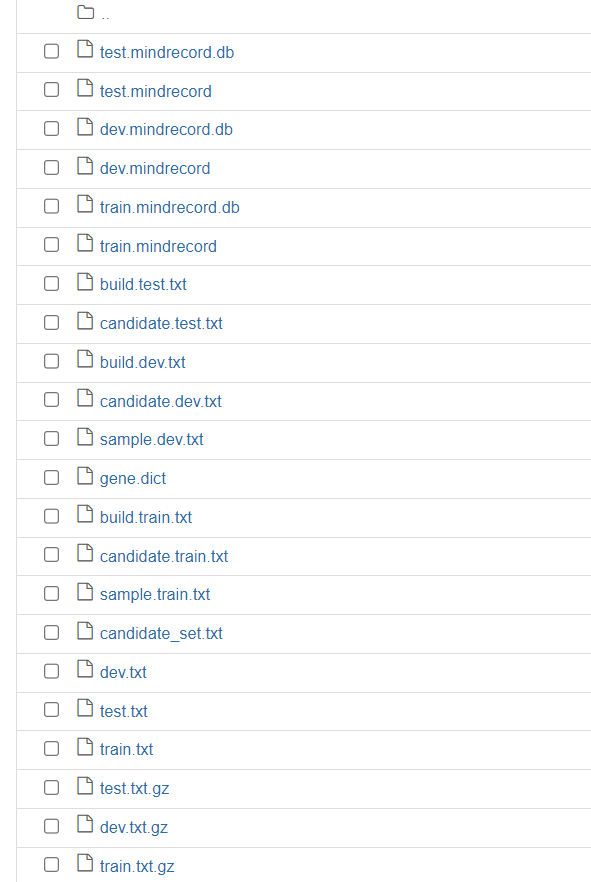

#### 使用定义的download函数通过三个url将分别用作训练的train.txt.gz、用作验证的dev.txt.gz、用作测试的test_1.txt.gz这三个压缩文件分别下载到当前目录下
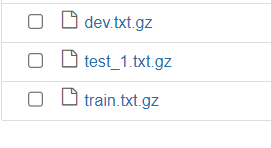

In [1]:
import requests
 
def download(url):
    req = requests.get(url)
    filename = url.split('/')[-1]
    if req.status_code != 200:
        print('下载异常')
        return
    try:
        with open(filename, 'wb') as f:
            #req.content为获取html的内容
            f.write(req.content)
            print('下载成功')
    except Exception as e:
        print(e)
 
 
if __name__ == '__main__':
    url = 'https://dataset-bj.cdn.bcebos.com/duconv/train.txt.gz'   # 
    download(url)
    ur2 = 'https://dataset-bj.cdn.bcebos.com/duconv/dev.txt.gz'   # 
    download(ur2)
    ur3 = 'https://dataset-bj.cdn.bcebos.com/duconv/test_1.txt.gz'   # 
    download(ur3)



/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


下载成功
下载成功
下载成功


#### 将test_1.txt.gz重命名为test.txt.gz，并将这三个压缩文件移动到data文件夹下
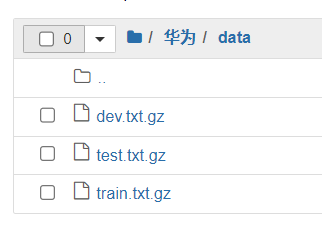

In [2]:
import os
from pathlib import Path
import shutil
if not os.path.exists('data'):
    os.makedirs('data')
os.rename('test_1.txt.gz', 'test.txt.gz')
shutil.move('./train.txt.gz', './data')
shutil.move('./dev.txt.gz', './data')
shutil.move('./test.txt.gz', './data')

'./data/test.txt.gz'

将三个gz文件解压为txt文件
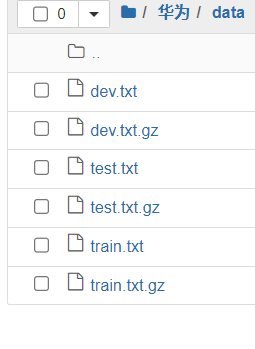

In [3]:
import gzip
def un_gz(file_name):
    # 获取文件的名称，去掉后缀名
    f_name = file_name.replace(".gz", "")
    # 开始解压
    g_file = gzip.GzipFile(file_name)
    # 读取解压后的文件，并写入去掉后缀名的同名文件（即得到解压后的文件）
    open(f_name, "wb+").write(g_file.read())
    g_file.close()

#将gz解压为txt
un_gz('./data/train.txt.gz')
un_gz('./data/dev.txt.gz')
un_gz('./data/test.txt.gz')

 #### 将下载下来的三个数据集截断为较小的数据集
 #### train 100行
 #### test 20行
 ##### dev 10行

In [4]:
import os


def slice_data(file_name,length):
    with open(file_name, encoding='utf-8') as fic:
        lines = [fic.readline() for _ in range(length)]
        fic.close()

    with open(file_name, 'w', encoding='utf-8') as fic:
        fic.writelines(lines)
        fic.close()
    return 0

slice_data('./data/train.txt',100)
slice_data('./data/test.txt',20)
slice_data('./data/dev.txt',10)

0

#### 数据预处理——生成candidate_set.txt文件


In [5]:
# 从语料库构建候选集

from __future__ import print_function
import sys
import json
import random
import collections


import functools


def cmp(a, b):
    len_a, len_b = len(a[1]), len(b[1])
    if len_a > len_b:
        return 1
    elif len_a < len_b:
        return -1
    else:
        return 0

# 从语料库文件中生成候选集
def build_candidate_set_from_corpus(corpus_file, candidate_set_file):

    candidate_set_gener = {}
    candidate_set_mater = {}
    candidate_set_list = []
    slot_dict = {"topic_a": 1, "topic_b": 1}
    with open(corpus_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            conversation = json.loads(line.strip(), encoding="utf-8",
                                      object_pairs_hook=collections.OrderedDict)

            chat_path = conversation["goal"]
            knowledge = conversation["knowledge"]
            session = conversation["conversation"]

            topic_a = chat_path[0][1]
            topic_b = chat_path[0][2]
            domain_a = None
            domain_b = None
            cover_att_list = [[["topic_a", topic_a],
                               ["topic_b", topic_b]]] * len(session)
            for j, [s, p, o] in enumerate(knowledge):
                p_key = ""
                if topic_a.replace(' ', '') == s.replace(' ', ''):
                    p_key = "topic_a_" + p.replace(' ', '')
                    if u"领域" == p:
                        domain_a = o
                elif topic_b.replace(' ', '') == s.replace(' ', ''):
                    p_key = "topic_b_" + p.replace(' ', '')
                    if u"领域" == p:
                        domain_b = o

                for k, utterance in enumerate(session):
                    if k % 2 == 1:
                        continue
                    if o in utterance and o != topic_a and o != topic_b and p_key != "":
                        cover_att_list[k].append([p_key, o])

                slot_dict[p_key] = 1

            assert domain_a is not None and domain_b is not None

            for j, utterance in enumerate(session):
                if j % 2 == 1:
                    continue
                key = '_'.join([domain_a, domain_b, str(j)])

                cover_att = sorted(
                    cover_att_list[j], key=functools.cmp_to_key(cmp), reverse=True)

                utterance_gener = utterance
                for [p_key, o] in cover_att:
                    utterance_gener = utterance_gener.replace(o, p_key)

                if "topic_a_topic_a_" not in utterance_gener and \
                   "topic_a_topic_b_" not in utterance_gener and \
                   "topic_b_topic_a_" not in utterance_gener and \
                   "topic_b_topic_b_" not in utterance_gener:
                    if key in candidate_set_gener:
                        candidate_set_gener[key].append(utterance_gener)
                    else:
                        candidate_set_gener[key] = [utterance_gener]

                utterance_mater = utterance
                for [p_key, o] in [["topic_a", topic_a], ["topic_b", topic_b]]:
                    utterance_mater = utterance_mater.replace(o, p_key)

                if key in candidate_set_mater:
                    candidate_set_mater[key].append(utterance_mater)
                else:
                    candidate_set_mater[key] = [utterance_mater]

                candidate_set_list.append(utterance_mater)

    fout = open(candidate_set_file, 'w')
    fout.write(json.dumps(candidate_set_gener, ensure_ascii=False) + "\n")
    fout.write(json.dumps(candidate_set_mater, ensure_ascii=False) + "\n")
    fout.write(json.dumps(candidate_set_list, ensure_ascii=False) + "\n")
    fout.write(json.dumps(slot_dict, ensure_ascii=False))
    fout.close()

#### 将对话转化为样本，生成对应的样本文件
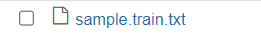

In [6]:
import sys
import json
import collections

# 采样
def convert_session_to_sample(session_file, sample_file):

    fout = open(sample_file, 'w', encoding='utf-8')
    with open(session_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            session = json.loads(line.strip(), encoding="utf-8",
                                 object_pairs_hook=collections.OrderedDict)
            conversation = session["conversation"]

            for j in range(0, len(conversation), 2):
                sample = collections.OrderedDict()
                sample["goal"] = session["goal"]
                sample["knowledge"] = session["knowledge"]
                sample["history"] = conversation[:j]
                sample["response"] = conversation[j]

                sample = json.dumps(sample, ensure_ascii=False)

                fout.write(sample + "\n")

    fout.close()

#### 选择合法的候选集

In [7]:
from __future__ import print_function
import sys
import json
import random
import collections

# 加载候选集，返回列表
def load_candidate_set(candidate_set_file):
  
    candidate_set = []
    for line in open(candidate_set_file):
        candidate_set.append(json.loads(line.strip(), encoding="utf-8"))

    return candidate_set

# 选择合法的候选
def candidate_slection(candidate_set, knowledge_dict, slot_dict, candidate_num=10):

    random.shuffle(candidate_set)
    candidate_legal = []
    for candidate in candidate_set:
        is_legal = True
        for slot in slot_dict:
            if slot in ["topic_a", "topic_b"]:
                continue
            if slot in candidate:
                if slot not in knowledge_dict:
                    is_legal = False
                    break
                w_ = random.choice(knowledge_dict[slot])
                candidate = candidate.replace(slot, w_)

        for slot in ["topic_a", "topic_b"]:
            if slot in candidate:
                if slot not in knowledge_dict:
                    is_legal = False
                    break
                w_ = random.choice(knowledge_dict[slot])
                candidate = candidate.replace(slot, w_)

        if is_legal and candidate not in candidate_legal:
            candidate_legal.append(candidate)

        if len(candidate_legal) >= candidate_num:
            break

    return candidate_legal

# 选择用于对话系统的候选集
def get_candidate_for_conversation(conversation, candidate_set, candidate_num=10):

    candidate_set_gener, candidate_set_mater, candidate_set_list, slot_dict = candidate_set

    chat_path = conversation["goal"]
    knowledge = conversation["knowledge"]
    history = conversation["history"]

    topic_a = chat_path[0][1]
    topic_b = chat_path[0][2]
    domain_a = None
    domain_b = None
    knowledge_dict = {"topic_a": [topic_a], "topic_b": [topic_b]}
    for i, [s, p, o] in enumerate(knowledge):
        p_key = ""
        if topic_a.replace(' ', '') == s.replace(' ', ''):
            p_key = "topic_a_" + p.replace(' ', '')
            if u"领域" == p:
                domain_a = o
        elif topic_b.replace(' ', '') == s.replace(' ', ''):
            p_key = "topic_b_" + p.replace(' ', '')
            if u"领域" == p:
                domain_b = o

        if p_key == "":
            continue

        if p_key in knowledge_dict:
            knowledge_dict[p_key].append(o)
        else:
            knowledge_dict[p_key] = [o]

    assert domain_a is not None and domain_b is not None

    key = '_'.join([domain_a, domain_b, str(len(history))])

    candidate_legal = []
    if key in candidate_set_gener:
        candidate_legal.extend(candidate_slection(candidate_set_gener[key],
                                                  knowledge_dict, slot_dict,
                                                  candidate_num=candidate_num - len(candidate_legal)))

    if len(candidate_legal) < candidate_num and key in candidate_set_mater:
        candidate_legal.extend(candidate_slection(candidate_set_mater[key],
                                                  knowledge_dict, slot_dict,
                                                  candidate_num=candidate_num - len(candidate_legal)))

    if len(candidate_legal) < candidate_num:
        candidate_legal.extend(candidate_slection(candidate_set_list,
                                                  knowledge_dict, slot_dict,
                                                  candidate_num=candidate_num - len(candidate_legal)))

    return candidate_legal


# 为语料库构建候选集
def construct_candidate_for_corpus(corpus_file, candidate_set_file, candidate_file, candidate_num=10):
    """
    construct candidate for corpus

    case of data in corpus_file:
    {
        "goal": [["START", "休 · 劳瑞", "蕾切儿 · 哈伍德"]],
        "knowledge": [["休 · 劳瑞", "评论", "完美 的 男人"]],
        "history": ["你 对 明星 有没有 到 迷恋 的 程度 呢 ？",
                    "一般 吧 ， 毕竟 年纪 不 小 了 ， 只是 追星 而已 。"]
    }

    case of data in candidate_file:
    {
        "goal": [["START", "休 · 劳瑞", "蕾切儿 · 哈伍德"]],
        "knowledge": [["休 · 劳瑞", "评论", "完美 的 男人"]],
        "history": ["你 对 明星 有没有 到 迷恋 的 程度 呢 ？",
                    "一般 吧 ， 毕竟 年纪 不 小 了 ， 只是 追星 而已 。"],
        "candidate": ["我 说 的 是 休 · 劳瑞 。",
                      "我 说 的 是 休 · 劳瑞 。"]
    }
    """
    candidate_set = load_candidate_set(candidate_set_file)
    fout_text = open(candidate_file, 'w', encoding="utf-8")
    with open(corpus_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            conversation = json.loads(line.strip(), encoding="utf-8",
                                      object_pairs_hook=collections.OrderedDict)
            candidates = get_candidate_for_conversation(conversation,
                                                        candidate_set,
                                                        candidate_num=candidate_num)
            conversation["candidate"] = candidates

            conversation = json.dumps(conversation, ensure_ascii=False)
            fout_text.write(conversation + "\n")

    fout_text.close()

#### 将对话语料库转换为符合模型输入的文本形式
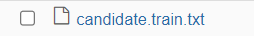

In [8]:
import sys
import re
import json
import collections
# from construct_candidate import get_candidate_for_conversation

# 为单词解析字符
def parser_char_for_word(word):

    if word.isdigit():
        return word
    for i in range(len(word)):
        if word[i] >= u'\u4e00' and word[i] <= u'\u9fa5':
            word_out = " ".join([t for t in word])
            word_out = re.sub(" +", " ", word_out)
            return word_out
    return word

# 为文本解析字符
def parser_char_for_text(text):

    words = text.strip().split()
    for i, word in enumerate(words):
        words[i] = parser_char_for_word(word)
    return re.sub(" +", " ", ' '.join(words))

# 文本的主题泛化
def topic_generalization_for_text(text, topic_list):

    for key, value in topic_list:
        text = text.replace(value, key)

    return text

# 列表的主题泛化
def topic_generalization_for_list(text_list, topic_list):

    for i, text in enumerate(text_list):
        text_list[i] = topic_generalization_for_text(text, topic_list)

    return text_list

# 一个对话的预处理
def preprocessing_for_one_conversation(text,
                                       candidate_num=10,
                                       use_knowledge=True,
                                       topic_generalization=False,
                                       for_predict=True):


    conversation = json.loads(text.strip(), encoding="utf-8",
                              object_pairs_hook=collections.OrderedDict)

    goal = conversation["goal"]
    knowledge = conversation["knowledge"]
    history = conversation["history"]
    if not for_predict:
        response = conversation["response"]

    topic_a = goal[0][1]
    topic_b = goal[0][2]
    for i, [s, p, o] in enumerate(knowledge):
        if u"领域" == p:
            if topic_a == s:
                domain_a = o
            elif topic_b == s:
                domain_b = o

    topic_dict = {}
    if u"电影" == domain_a:
        topic_dict["video_topic_a"] = topic_a
    else:
        topic_dict["person_topic_a"] = topic_a

    if u"电影" == domain_b:
        topic_dict["video_topic_b"] = topic_b
    else:
        topic_dict["person_topic_b"] = topic_b

    if "candidate" in conversation:
        candidates = conversation["candidate"]
    else:
        assert candidate_num > 0
        candidates = get_candidate_for_conversation(conversation,
                                                    candidate_num=candidate_num)

    if topic_generalization:
        topic_list = sorted(topic_dict.items(),
                            key=lambda item: len(item[1]), reverse=True)

        goal = [topic_generalization_for_list(spo, topic_list) for spo in goal]

        knowledge = [topic_generalization_for_list(
            spo, topic_list) for spo in knowledge]

        history = [topic_generalization_for_text(utterance, topic_list)
                   for utterance in history]

        for i, candidate in enumerate(candidates):
            candidates[i] = topic_generalization_for_text(
                candidate, topic_list)

        if not for_predict:
            response = topic_generalization_for_text(response, topic_list)

    goal = ' [PATH_SEP] '.join([parser_char_for_text(' '.join(spo))
                                for spo in goal])
    knowledge = ' [KN_SEP] '.join([parser_char_for_text(' '.join(spo))
                                   for spo in knowledge])
    history = ' [INNER_SEP] '.join([parser_char_for_text(utterance)
                                    for utterance in history]) \
        if len(history) > 0 else '[START]'

    model_text = []

    for candidate in candidates:
        candidate = parser_char_for_text(candidate)
        if use_knowledge:
            text_ = '\t'.join(["0", history, candidate, goal, knowledge])
        else:
            text_ = '\t'.join(["0", history, candidate])

        text_ = re.sub(" +", " ", text_)
        model_text.append(text_)

    if not for_predict:
        candidates.append(response)
        response = parser_char_for_text(response)
        if use_knowledge:
            text_ = '\t'.join(["1", history, response, goal, knowledge])
        else:
            text_ = '\t'.join(["1", history, response])

        text_ = re.sub(" +", " ", text_)
        model_text.append(text_)

    return model_text, candidates

# 将对话语料库转换为模型文本
def convert_conversation_corpus_to_model_text(corpus_file, text_file,
                                              use_knowledge=True,
                                              topic_generalization=False,
                                              for_predict=True):

    fout_text = open(text_file, 'w', encoding='utf-8')
    with open(corpus_file, 'r',encoding='utf-8') as f:
        for i, line in enumerate(f):
            model_text, _ = preprocessing_for_one_conversation(
                line.strip(), candidate_num=0,
                use_knowledge=use_knowledge,
                topic_generalization=topic_generalization,
                for_predict=for_predict)

            for text in model_text:
                fout_text.write(text + "\n")

    fout_text.close()

#### 根据准备的文本数据，构建字符级字典
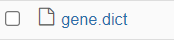

In [9]:
import sys

# 构建字典
def build_dict(corpus_file, dict_file):

    dict = {}
    max_frequency = 1
#     for line in open(corpus_file, 'r', encoding='utf-8'):
    with open(corpus_file,'r',encoding='utf-8') as f:
        for line in f:
            conversation = line.strip().split('\t')
            for i in range(1, len(conversation), 1):
                words = conversation[i].split(' ')
                for word in words:
                    if word in dict:
                        dict[word] = dict[word] + 1
                        if dict[word] > max_frequency:
                            max_frequency = dict[word]
                    else:
                        dict[word] = 1

        dict["[PAD]"] = max_frequency + 4
        dict["[UNK]"] = max_frequency + 3
        dict["[CLS]"] = max_frequency + 2
        dict["[SEP]"] = max_frequency + 1

        words = sorted(dict.items(), key=lambda item: item[1], reverse=True)

        fout = open(dict_file, 'w', encoding='utf-8')
        for word, frequency in words:
            fout.write(word + '\n')

        fout.close()

#### 通过txt生成如下文件
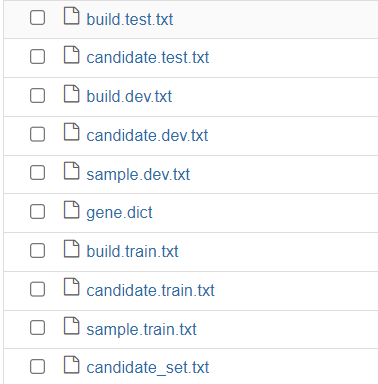

In [10]:
# 数据预处理
# match_kn_gene
DICT_NAME = "data/gene.dict"
USE_KNOWLEDGE = 1
TOPIC_GENERALIZATION = 1

FOR_PREDICT = 0
CANDIDATE_NUM = 9
# data目录下的tarin.txt,dev.txt,test.txt都已作截断处理，长度分别为100行，10行和20行
DATA_TYPE = ['train', 'dev', 'test']
INPUT_PATH = 'data/'
candidate_set_file = 'data/candidate_set.txt'
for i in range(len(DATA_TYPE)):
    corpus_file = 'data/{DATA}.txt'.format(DATA=DATA_TYPE[i])
    sample_file = 'data/sample.{DATA}.txt'.format(DATA=DATA_TYPE[i])
    candidate_file = 'data/candidate.{DATA}.txt'.format(DATA=DATA_TYPE[i])
    text_file = 'data/build.{DATA}.txt'.format(DATA=DATA_TYPE[i])

    # 步骤1：从消极训练案例的会话数据构建候选集，并预测候选对象
    if DATA_TYPE[i] == 'train':
        build_candidate_set_from_corpus(corpus_file, candidate_set_file)
#         build_dict(text_file, DICT_NAME)

    # 步骤2:首先要将会话数据转换为样本数据
    if DATA_TYPE[i] == 'test':
        sample_file = corpus_file
        FOR_PREDICT = 1
        CANDIDATE_NUM = 10
    else:
        convert_session_to_sample(corpus_file, sample_file)

    # 步骤3:为样本数据构造候选项
    construct_candidate_for_corpus(sample_file, candidate_set_file,
                                   candidate_file, CANDIDATE_NUM)

    # 步骤4:将带有候选项的样本数据转换为模型所需的文本数据
    convert_conversation_corpus_to_model_text(
        candidate_file, text_file, USE_KNOWLEDGE, TOPIC_GENERALIZATION, FOR_PREDICT)

    # 步骤5:从训练数据建立字典，这里我们为模型建立字符字典
    if DATA_TYPE[i] == "train":
        build_dict(text_file, DICT_NAME)

#### 利用mindspore将txt文本数据转换格式为.mindrecord数据

In [11]:
import argparse
from typing import Sequence
import numpy as np
from mindspore.mindrecord import FileWriter
from mindspore.log import logging

# 利用mindspore将txt文本数据转换格式为.mindrecord数据
# 加载字典
def load_dict(vocab_path): 

    vocab_dict = {}
    idx = 0
    for line in open(vocab_path,encoding='utf-8'): 
        line = line.strip()
        vocab_dict[line] = idx
        idx += 1
    return vocab_dict

class DataProcessor:
    def __init__(self, task_name, vocab_path, max_seq_len, do_lower_case):
        self.task_name = task_name
        self.max_seq_len = max_seq_len
        self.do_lower_case = do_lower_case
        self.vocab_dict = load_dict(vocab_path)

    def get_labels(self):
        return ["0", "1"]

    def _read_data(self, input_file):
        lines = []
        with open(input_file, 'r',encoding='utf-8') as f:
            for line in f:
                line = line.rstrip('\n').split('\t')
                lines.append(line)
        return lines
# 为训练集和验证集创造示例
    def _create_examples(self, input_file):

        examples = []
        lines = self._read_data(input_file)
        for line in lines:
            context_text = line[1]
            label_text = line[0]
            response_text = line[2]
            if 'kn' in self.task_name: 
                kn_text = "%s [SEP] %s" % (line[3], line[4])
            else: 
                kn_text = None
            examples.append(
                InputExample(context_text=context_text, response_text=response_text, \
                             kn_text=kn_text, label_text=label_text))
        return examples
# 转化
    def _convert_example_to_record(self, example, labels, max_seq_len, vocab_dict):
   
        feature = convert_single_example(example, labels, max_seq_len, vocab_dict)
        return feature
# 将InputExample转化为 MindDataset文件
    def file_based_convert_examples_to_features(self, input_file, output_file):

        examples = self._create_examples(input_file)

        writer = FileWriter(file_name=output_file, shard_num=1)
        nlp_schema = {
            "context_id": {"type": "int64", "shape": [-1]},
            "context_segment_id": {"type": "int64", "shape": [-1]},
            "context_pos_id": {"type": "int64", "shape": [-1]},
            "labels_list": {"type": "int64", "shape": [-1]}
        }
        if 'kn' in self.task_name:
            nlp_schema['kn_id'] = {"type": "int64", "shape": [-1]}
            nlp_schema['kn_seq_length'] = {"type": "int64", "shape": [-1]}

        writer.add_schema(nlp_schema, "proprocessed dataset")
        data = []
        for index, example in enumerate(examples):
            if index % 10000 == 0:
                logging.info("Writing example %d of %d" % (index, len(examples)))
            record = self._convert_example_to_record(example, self.get_labels(), self.max_seq_len, self.vocab_dict)
            sample = {
                "context_id": np.array(record.context_ids, dtype=np.int64),
                "context_pos_id": np.array(record.context_pos_ids, dtype=np.int64),
                "context_segment_id": np.array(record.segment_ids, dtype=np.int64),
                "labels_list": np.array([record.label_ids], dtype=np.int64),
            }
            if 'kn' in self.task_name:
                sample['kn_id'] = np.array(record.kn_ids, dtype=np.int64)
                sample['kn_seq_length'] = np.array(record.kn_seq_length, dtype=np.int64)
                
            data.append(sample)
        writer.write_raw_data(data)
        writer.commit()
# 一个单独的训练样例
class InputExample(object):


    def __init__(self, context_text, response_text, kn_text, label_text):
        self.context_text = context_text
        self.response_text = response_text
        self.kn_text = kn_text
        self.label_text = label_text
# 输入特性数据
class InputFeatures(object): 

    def __init__(self, context_ids, context_pos_ids, segment_ids, kn_ids, kn_seq_length, label_ids): 
        self.context_ids = context_ids
        self.context_pos_ids = context_pos_ids
        self.segment_ids = segment_ids
        self.kn_ids = kn_ids
        self.kn_seq_length = kn_seq_length
        self.label_ids = label_ids
#  转换输入
def convert_tokens_to_ids(tokens, vocab_dict): 

    ids = []
    for token in tokens: 
        if token in vocab_dict: 
            ids.append(vocab_dict[token])
        else: 
            ids.append(vocab_dict['[UNK]'])
    return ids
# 把InputExample转换为InputFeatures
def convert_single_example(example, label_list, max_seq_length, vocab_dict):

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i
    if example.context_text: 
        tokens_context = example.context_text
        tokens_context = tokens_context.split()
    else: 
        tokens_context = []

    if example.response_text: 
        tokens_response = example.response_text
        tokens_response = tokens_response.split()
    else: 
        tokens_response = []

    if example.kn_text:
        tokens_kn = example.kn_text
        tokens_kn = tokens_kn.split()
        tokens_kn = tokens_kn[0: min(len(tokens_kn), max_seq_length)]
    else: 
        tokens_kn = []

    tokens_response = tokens_response[0: min(50, len(tokens_response))]
    if len(tokens_context) > max_seq_length - len(tokens_response) - 3: 
        tokens_context = tokens_context[len(tokens_context) \
                + len(tokens_response) - max_seq_length + 3:]

    context_tokens = []
    segment_ids = []

    context_tokens.append("[CLS]")
    segment_ids.append(0)
    context_tokens.extend(tokens_context)
    segment_ids.extend([0] * len(tokens_context))
    context_tokens.append("[SEP]")
    segment_ids.append(0)

    context_tokens.extend(tokens_response)
    segment_ids.extend([1] * len(tokens_response))
    context_tokens.append("[SEP]")
    segment_ids.append(1)

    context_ids = convert_tokens_to_ids(context_tokens, vocab_dict)
    context_ids = context_ids + [0] * (max_seq_length - len(context_ids))
    context_pos_ids = list(range(len(context_ids))) + [0] * (max_seq_length - len(context_ids))
    segment_ids = segment_ids + [0] * (max_seq_length - len(segment_ids))
    label_ids = label_map[example.label_text]
    if tokens_kn: 
        kn_ids = convert_tokens_to_ids(tokens_kn, vocab_dict)
        kn_ids = kn_ids[0: min(max_seq_length, len(kn_ids))]
        kn_seq_length = len(kn_ids)
        kn_ids = kn_ids + [0] * (max_seq_length - kn_seq_length)
    else: 
        kn_ids = []
        kn_seq_length = 0

    feature = InputFeatures(
        context_ids=context_ids,
        context_pos_ids=context_pos_ids,
        segment_ids=segment_ids,
        kn_ids = kn_ids,
        kn_seq_length=kn_seq_length,
        label_ids=label_ids)

    return feature

def reader_main(task_name,vocab_path,max_seq_len,input_file,output_file,do_lower_case=''):

    processer = DataProcessor(task_name, vocab_path, max_seq_len, True if do_lower_case == "true" else False)
    processer.file_based_convert_examples_to_features(input_file, output_file)

#### 生成并存储最终的mindrecord文件
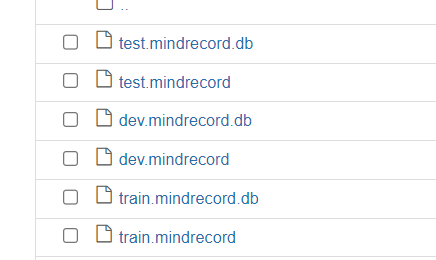

In [12]:
reader_main(task_name='match_kn_gene', vocab_path='data/gene.dict', max_seq_len=256,
            input_file='data/build.train.txt', output_file='data/train.mindrecord')
reader_main(task_name='match_kn_gene', vocab_path='data/gene.dict', max_seq_len=256,
            input_file='data/build.dev.txt', output_file='data/dev.mindrecord')
reader_main(task_name='match_kn_gene', vocab_path='data/gene.dict', max_seq_len=256,
            input_file='data/build.test.txt', output_file='data/test.mindrecord')
